### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
import pydot
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-12-01 16:39:13.908143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 16:39:13.908164: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final.csv', header=1)
df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']

Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
df['Graphene_Yield'] = 100*df['Graphene_Yield']
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)

In [3]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)
# extra material descriptors
# Cabot BP2000: Tensile Strength=17 MPa, particle size=15nm, specific surface area=1500(m2/g)
# metallurgical coke: grain size=150-210 (um)
# pyrolysis ash: 
# pyrolyzed rubber tire-derived carbon black: 

In [4]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [5]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)

(0.7261024524604334, 1.641345629149422e-10)
(0.5812794795939819, 2.124196571910361e-06)


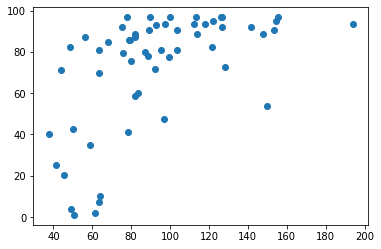

In [6]:
voltage_CB = df['Voltage'].loc[df['Material']=='CB']
mass_CB = df['Mass'].loc[df['Material']=='CB']
cap_CB = df['Cap'].loc[df['Material']=='CB']
GY_CB = df['Graphene_Yield'].loc[df['Material']=='CB']
CD_CB = df['charge_density'].loc[df['Material']=='CB']
prevol_CB = df['Pretreat_voltage'].loc[df['Material']=='CB']
prevolhighest_CB = df['Pretreat_voltage'].loc[df['Material']=='CB']
I_Max_CB = df['I_Max'].loc[df['Material']=='CB']
I_Mean_CB = df['I_Mean'].loc[df['Material']=='CB']
charge_tot_CB = df['Charge_Tot'].loc[df['Material']=='CB']

plt.scatter (((voltage_CB**1)/(mass_CB**-1)*(cap_CB**1))**1*1e-8
                +(prevol_CB**0.5) 
                +(I_Max_CB**0.8)
                +(charge_tot_CB**1)
                ,GY_CB)

print (pearsonr((voltage_CB**1)/(mass_CB**0.5)*(cap_CB**0.5) 
                +(prevol_CB**0.5) 
                +(I_Max_CB**0.8)
                +(charge_tot_CB**1)
                ,GY_CB))
print (pearsonr((voltage_CB**1)/(mass_CB**1)*cap_CB**1, GY_CB))

mean r2:  0.36820773459643663
mean pearson r:  0.6774600263775616
coef_:  [ 0.02406689 -0.00291398 -0.01218679 -0.00883577  0.00516408 -0.01620758
  0.00024003 -0.0139576  -0.0052297 ]
Gamma score: 0.5337952725128021
r-squared 0.6020820385042721
mse:  0.02476901626840307
pearson r (0.7962755676048487, 1.0660849528819874e-08)


Text(0, 0.5, 'Pred. I_Final/I_Max')

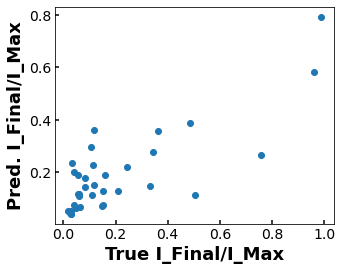

In [10]:
# Final_Current_Percent as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Final_Current_Percent
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                 Res_Drop, Volt_Drop, Graphene_Yield), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 200):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.4, random_state=i)
    clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# get the average of all coef with different random states.
CB_MC_PA_coef_Final_Current_Percent = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=7)
clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True I_Final/I_Max', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. I_Final/I_Max', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Final_Current_Percent), np.max(Final_Current_Percent), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

mean r2:  0.571592520236972
mean pearson r:  0.7855922912032477
coef_:  [ 0.00011893 -0.00031649  0.00138312 -0.00118387 -0.03918107  0.00720841
  0.00527762  0.00270649  0.01279077 -0.03316151  0.00316424]
Gamma score: 0.5237834892762123
r-squared 0.7247958460695246
mse:  137875.4841731152
pearson r (0.8559894680670143, 5.591203879361779e-11)


Text(0, 0.5, 'Pred. Norm_I_Max')

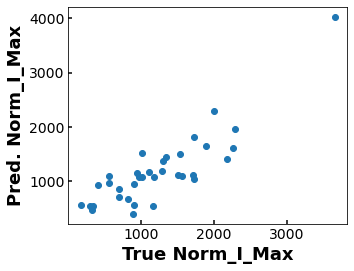

In [11]:
# Norm_I_Max as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_I_Max
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                 Res_Drop, Volt_Drop), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 200):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=i)
    clf = linear_model.GammaRegressor(alpha=0.1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# get the average of all coef with different random states.
CB_MC_PA_coef_Norm_I_Max = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=7)
clf = linear_model.GammaRegressor(alpha=0.1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True Norm_I_Max', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. Norm_I_Max', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Norm_I_Max), np.max(Norm_I_Max), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

mean r2:  0.5151541661477035
mean pearson r:  0.7789288745661703
Gamma score: 0.6264453660867094
r-squared 0.7466508625463539
mse:  196.9378468309179
pearson r (0.8682476781264775, 1.4173048400529228e-11)


Text(0, 0.5, 'Pred. Norm_charge_tot')

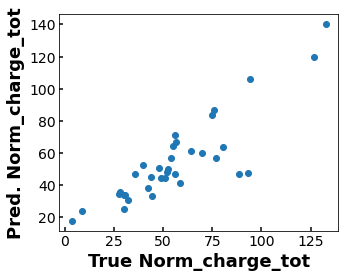

In [12]:
# Norm_charge_tot as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_charge_tot
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 Res_Drop, Volt_Drop), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 200):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=i)
    clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# get the average of all coef with different random states.
CB_MC_PA_coef_Norm_charge_tot = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=7)
clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
#print ('coef_: ', clf.coef_)

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True Norm_charge_tot', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. Norm_charge_tot', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Norm_charge_tot), np.max(Norm_charge_tot), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

In [13]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

In [14]:
# proxy (current-time plot) prediction (Final_Current_percent)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=7
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_CB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']
new_features[0]

array([ 1.12800000e+02,  1.20000000e+03,  2.88461393e-02, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.00000000e+01])

In [15]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(50):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.01, 
                   learning_rate=0.115, subsample=0.77, min_child_weight=8, 
                   random_state=random_state)
    #xgbr_final_I_percent = RandomForestRegressor(max_depth=20, n_estimators=500, min_samples_split=3)
    # xgbr_final_I_percent = linear_model.BayesianRidge()
    # xgbr_final_I_percent = XGBRegressor()
    # Train the model on training data
    labels = Final_Current_Percent
    xgbr_final_I_percent.fit(train_new_features, train_labels);
    #print('Doneskies')
    Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
    r_squareds.append(r_squared_Final_Current_test)
    
    r_pearson_Final_Current_test = pearsonr(test_labels.reshape(test_labels.shape[0],), 
                                            Final_Current_Percent_test.reshape(Final_Current_Percent_test.shape[0],))
    r_pearsons.append(r_pearson_Final_Current_test[0])   
    
    Final_Current_Percent_train = xgbr_final_I_percent.predict(train_new_features)
    r_squared_Final_Current_train = r2_score(train_labels, Final_Current_Percent_train)
    r_squareds_train.append(r_squared_Final_Current_train)    

print ('Average of r pearson for test', np.mean(np.array(r_pearsons)))
print ('std of r pearson for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

xgbr_final_I_percent.fit(new_features, labels)
# Use the forest's predict method on the test data
Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)
# Calculate the absolute errors
errors = abs(Final_Current_Percent_predicted - Final_Current_Percent)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Final_Current_all = r2_score(Final_Current_Percent, Final_Current_Percent_predicted)
print('r2 score = ', r_squared_Final_Current_all)

# Use the forest's predict method on the test data
Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Final_Current_Percent_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
print('r2 score = ', r_squared_Final_Current_test)

Average of r pearson for test 0.662233759904468
std of r pearson for test 0.01727561018799209 

Average of r_squared for test 0.4204675768230646
std of r_squared for test 0.021021623655164967 

Average of r_squared for train 0.8092938872010177
std of r_squared for train 0.007244344038685593
Mean Absolute Error: 0.2072 units.
r2 score =  0.777848107305179
Mean Absolute Error: 0.1933 units.
r2 score =  0.6985276297828256


In [16]:
# Get numerical feature importances
importances = list(xgbr_final_I_percent.feature_importances_)
print (importances)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

[0.07375926, 0.48786104, 0.06047855, 0.11870212, 0.0075992225, 0.037053633, 0.059584334, 0.0, 0.15496178]
Variable: charge_denisty Importance: ('charge_denisty', 0.07)
Variable: PulseTime Importance: ('PulseTime', 0.49)
Variable: material_CB Importance: ('material_CB', 0.06)
Variable: material_MC Importance: ('material_MC', 0.12)
Variable: material_PA Importance: ('material_PA', 0.01)
Variable: material_CB Importance: ('material_CB', 0.04)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.0)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.15)


In [17]:
# proxy (current-time plot) prediction (Norm_I_Max)
new_features = np.concatenate ((charge_denisty,
                                #np.array (df['Voltage']).reshape(-1, 1),
                                pulsetime,
                                material_type_Norm_I_Max_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=0
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

(0.7895080655700772, 1.731054934952032e-08)
Average of pearson r for test 0.7810154834756273
std of pearson 1 for test 0.01008559249330929 

Average of r_squared for test 0.573356679659293
std of r_squared for test 0.013405545283271307 

Average of r_squared for train 0.6920682071470152
std of r_squared for train 0.006170619174382692
Mean Absolute Error: 718.5204 units.
r2 score =  0.690673533208469
Mean Absolute Error: 715.1021 units.
r2 score =  0.692127316379529


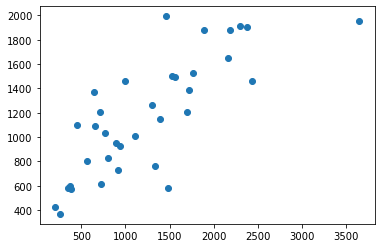

In [18]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    
    xgbr_norm_I_max = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=6, 
                  random_state=random_state)
    
    #xgbr_norm_I_max = RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_split=3)
    # xgbr_norm_I_max = linear_model.BayesianRidge()
    # xgbr_norm_I_max = XGBRegressor()
    # Train the model on training data
    labels = Norm_I_Max
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)

    test_labels_ = test_labels.reshape(test_labels.shape[0], )

    Norm_I_Max_test_ = Norm_I_Max_test.reshape(Norm_I_Max_test.shape[0], )

    r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
    r_pearsons.append(r_pearson_Norm_I_Max_test[0])
    r_squareds.append(r_squared_Norm_I_Max_test)
    
    Norm_I_Max_train = xgbr_norm_I_max.predict(train_new_features)
    r_squared_Norm_I_Max_train = r2_score(train_labels, Norm_I_Max_train)
    r_squareds_train.append(r_squared_Norm_I_Max_train)  

r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
print (r_pearson_Norm_I_Max_test)
plt.scatter(test_labels_, Norm_I_Max_test_)
print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')
print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')
print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

xgbr_norm_I_max.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_I_Max_predicted - Norm_I_Max)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_I_Max_all = r2_score(Norm_I_Max, Norm_I_Max_predicted)
print('r2 score = ', r_squared_Norm_I_Max_all)

# Use the forest's predict method on the test data
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_I_Max_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
print('r2 score = ', r_squared_Norm_I_Max_test)

In [19]:
# Get numerical feature importances
importances = list(xgbr_norm_I_max.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];
print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.14)
Variable: PulseTime Importance: ('PulseTime', 0.03)
Variable: material_CB Importance: ('material_CB', 0.0)
Variable: material_MC Importance: ('material_MC', 0.55)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_TCB Importance: ('material_TCB', 0.06)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.0)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.14)
[0.14157231, 0.02969831, 0.0, 0.5455658, 0.0, 0.06243607, 0.0, 0.08547817, 0.13524945]


In [20]:
# proxy (current-time plot) prediction (Norm_Norm_charge_tot)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=0
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

In [21]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_norm_charge_total = XGBRegressor(max_depth=10, n_estimators=100, gamma=0.01, 
                   learning_rate=0.118, subsample=0.75, min_child_weight=2, 
                  random_state=random_state)
    #xgbr_norm_charge_total = RandomForestRegressor(max_depth=5, n_estimators=200, min_samples_split=3)
    # xgbr_norm_charge_total = linear_model.BayesianRidge()
    # xgbr_norm_charge_total = XGBRegressor()
    # Train the model on training data
    labels = Norm_charge_tot
    xgbr_norm_charge_total.fit(train_new_features, train_labels);
    #print('Doneskies')
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    r_squareds.append(r_squared_Norm_charge_tot_test)
    
    test_labels_ = test_labels.reshape(test_labels.shape[0], )
    Norm_charge_tot_test_ = Norm_charge_tot_test.reshape(Norm_charge_tot_test.shape[0], )
    r_pearson_Norm_charge_tot_test = pearsonr(test_labels_, Norm_charge_tot_test_)
    r_pearsons.append(r_pearson_Norm_charge_tot_test[0])

    
    Norm_charge_tot_train = xgbr_norm_charge_total.predict(train_new_features)
    r_squared_Norm_charge_tot_train = r2_score(train_labels, Norm_charge_tot_train)
    r_squareds_train.append(r_squared_Norm_charge_tot_train)    

print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))


xgbr_norm_charge_total.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_charge_tot_predicted - Norm_charge_tot)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_charge_tot_all = r2_score(Norm_charge_tot, Norm_charge_tot_predicted)
print('r2 score = ', r_squared_Norm_charge_tot_all)

# Use the forest's predict method on the test data
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_charge_tot_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
print('r2 score = ', r_squared_Norm_charge_tot_test)

Average of pearson r for test 0.762857267170948
std of pearson 1 for test 0.02562412003965354 

Average of r_squared for test 0.5492208940617689
std of r_squared for test 0.034717596485303946 

Average of r_squared for train 0.9992018799936646
std of r_squared for train 0.00020163820884514097
Mean Absolute Error: 34.65 units.
r2 score =  0.9993209585434534
Mean Absolute Error: 37.4597 units.
r2 score =  0.9991980110720922


In [22]:
# Get numerical feature importances
importances = list(xgbr_norm_charge_total.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.12)
Variable: PulseTime Importance: ('PulseTime', 0.13)
Variable: material_CB Importance: ('material_CB', 0.08)
Variable: material_MC Importance: ('material_MC', 0.22)
Variable: material_PA Importance: ('material_PA', 0.03)
Variable: material_TCB Importance: ('material_TCB', 0.18)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.1)
[0.115658134, 0.13434337, 0.07814488, 0.21513005, 0.02933864, 0.18005373, 0.06032598, 0.085444376, 0.10156079]


In [23]:
print (CB_MC_PA_coef_Final_Current_Percent)
print (CB_MC_PA_coef_Norm_I_Max)
print (CB_MC_PA_coef_Norm_charge_tot)
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3
print (CB_MC_PA_TCB_coef_average)



[ 0.02884614 -0.00783737 -0.00505479 -0.01593003]
[ 0.00064174  0.00176005 -0.0017321  -0.0006698 ]
[ 0.01239714 -0.00277073 -0.0109499   0.00130863]
[ 0.01396167 -0.00294935 -0.00591226 -0.00509707]


0.7635631254941582


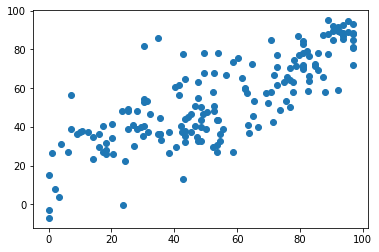

In [24]:
# linearly relate the input paramters to the final Graphene Yield
# assume constant resisitivity for precursors
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
voltage_ALL = np.array (df['Voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
mass_ALL = np.array (df['Mass'].loc[df['Material']!='AAA']).reshape(-1, 1)
cap_ALL = np.array (df['Cap'].loc[df['Material']!='AAA']).reshape(-1, 1)
GY_ALL = np.array (df['Graphene_Yield'].loc[df['Material']!='AAA']).reshape(-1, 1)
CD_ALL = np.array (df['charge_density'].loc[df['Material']!='AAA']).reshape(-1, 1)
prevol_ALL = np.array (df['Pretreat_voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
prevolhighest_ALL = np.array (df['Pretreat_voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
I_Max_ALL = np.array (df['I_Max'].loc[df['Material']!='AAA']).reshape(-1, 1)
I_Mean_ALL = np.array (df['I_Mean'].loc[df['Material']!='AAA']).reshape(-1, 1)
charge_tot_ALL = np.array (df['Charge_Tot'].loc[df['Material']!='AAA']).reshape(-1, 1)
pulsetime_ALL = np.array (df['PulseTime'].loc[df['Material']!='AAA']).reshape(-1, 1)
maxima_ALL = np.array (df['Maxima'].loc[df['Material']!='AAA']).reshape(-1, 1)


                                #Final_Current_Percent_predicted.reshape(-1, 1),
                                #Norm_I_Max_predicted.reshape(-1, 1),
                                #Norm_charge_tot_predicted.reshape(-1, 1), 
"""
1) (voltage_ALL**1*((mass_ALL)**-1)*(cap_ALL**1))**1
2) material_type_GY_coef

"""
"""

"""


input_features = np.concatenate (
    (((voltage_ALL**1*((mass_ALL)**1)*(cap_ALL**1))**1) + (prevol_ALL**1)*1e-2
     , cap_ALL*1e-1
     , ((Norm_I_Max_predicted.reshape(-1, 1)**1))   
     #, X_poly
     , np.multiply((((Norm_charge_tot_predicted.reshape(-1, 1))**2)), resistance_matrix.reshape(-1, 1))*1e-3
     , Final_Current_Percent_predicted.reshape(-1, 1)
     ,1+(pulsetime_ALL**1)+(pulsetime_ALL**2)
     #, heat_power
     , voltage_ALL**1
        #, mass_ALL*1e-2 
     , (X_CB_MC_PA_TCB_ps_res_sa_sp2 [df['Material']!='AAA'])**1
     #+ (material_type_GY_coef**1)
                                   ), axis=1)
#input_features = np.array (voltage_ALL**1*((mass_ALL)**-1)*(cap_ALL**2))**1
max_gamma_score = 0
pearsonrS = []
coefS_best5 = []
pearsonrS_all = []

coefS = []
interceptS = []
interceptS_best5 = []
for rand in range(0, 500):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_ALL, test_size=0.2, random_state=rand)
    phys_reg_mdl = linear_model.LinearRegression()
    phys_reg_mdl = phys_reg_mdl.fit(X_train, y_train.ravel())
    y_pred = phys_reg_mdl.predict(X_test)
    pearr = pearsonr(y_pred, y_test)
    pearsonrS.append(pearr[0])
    coefS.append(phys_reg_mdl.coef_)
    interceptS.append(phys_reg_mdl.intercept_)
    y_predall = phys_reg_mdl.predict(input_features)
    pearr_all = pearsonr(y_predall, GY_ALL)
    pearsonrS_all.append(pearr_all[0])
    if pearr_all[0] > 0.796:
        coefS_best5.append(phys_reg_mdl.coef_)
        interceptS_best5.append(phys_reg_mdl.intercept_)
print (np.mean(pearsonrS))

phys_reg_mdl_meancoef = coefS_best5[0]
phys_reg_mdl_meaninter = interceptS_best5[0]

y_pred = np.matmul(input_features, phys_reg_mdl_meancoef.reshape(-1, 1)) + phys_reg_mdl_meaninter
plt.scatter (Graphene_Yield, y_pred)

In [57]:
# assume constant resisitivity for precursors
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']/resistance_matrix*df['PulseTime']*(1e-6)).reshape(-1, 1)
# got it from model based prediction of I_Max
# got it from model based prediction of I_Max
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
# Porxy properties, as well as process parameters
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                y_pred.reshape(-1, 1),
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1)
                                ), axis=1)

rand=7
test_size = 0.2
indices = np.arange(len(new_features))
labels = Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state = rand
                                       #,stratify=df['Material']
                                      )

feature_list = ['charge_denisty',
                'material_ps',
                'material_res',
                'material_sa',
                'material_sp2',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                'physicsbased_model',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']

In [26]:
# stratify added to put same ratio of precursors in test and train
CB_count = sum(df['Material']=='CB')
MC_count = sum(df['Material']=='MC')
PA_count = sum(df['Material']=='PA')
TCB_count = sum(df['Material']=='TCB')
total = CB_count + MC_count + PA_count + TCB_count
print ('CB_count', CB_count, round(CB_count/total, 2),"% of total", total)
print ('MC_count', MC_count, round(MC_count/total, 2),"% of total", total)
print ('PA_count', PA_count, round(PA_count/total, 2),"% of total", total)
print ('TCB_count', TCB_count, round(TCB_count/total, 2),"% of total", total)

print ('CB count for testing {}% is {}'.format(test_size, round(test_size*CB_count, 0)))
print (sum (df['Material'][idx_test]=='CB'))
print ('MC count for testing {}% is {}'.format(test_size, round(test_size*MC_count, 0)))
print (sum (df['Material'][idx_test]=='MC'))
print ('PA count for testing {}% is {}'.format(test_size, round(test_size*PA_count, 0)))
print (sum (df['Material'][idx_test]=='PA'))
print ('TCB count for testing {}% is {}'.format(test_size, round(test_size*TCB_count, 0)))
print (sum (df['Material'][idx_test]=='TCB'))

CB_count 57 0.33 % of total 174
MC_count 44 0.25 % of total 174
PA_count 36 0.21 % of total 174
TCB_count 37 0.21 % of total 174
CB count for testing 0.2% is 11.0
6
MC count for testing 0.2% is 9.0
7
PA count for testing 0.2% is 7.0
14
TCB count for testing 0.2% is 7.0
8


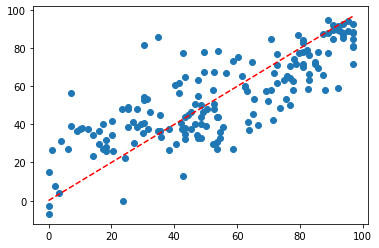

In [27]:
plt.scatter(Graphene_Yield, y_pred)
mid_line = list(np.linspace(np.min(GY_ALL), np.max(GY_ALL), 8))
plt.plot(mid_line, mid_line, '--', color='red')

In [28]:
CB_MC_PA_TCB_ps_res_sa_sp2

array([[4.50e+01, 2.80e+00, 1.75e+03, 4.12e+01],
       [1.50e+02, 4.00e-01, 1.80e+01, 4.59e+01],
       [1.25e+02, 7.20e+00, 6.20e+01, 4.24e+01],
       [1.06e+02, 6.30e+00, 7.40e+01, 3.06e+01]])

RMSE for test,  13.486581
0.7590344398342164
sd of random runs 0.023865332074493907


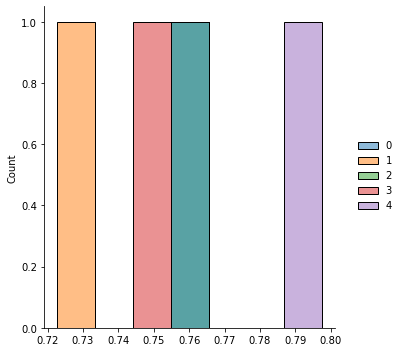

In [75]:
# focus on XGBoost, Similar to Jacob, !!!!5 train/test split iterations!!!!
r_squareds = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
r2_max = 0
test_split_seed1 = 8
test_split_seed2 = 9
test_split_count = test_split_seed2 - test_split_seed1
rep1 = 0
rep2 = 5
for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       #,stratify=df['Material']
                                       )
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(rep1, rep2):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=3, n_estimators=40, gamma=0.01, 
                   learning_rate=0.118, subsample=0.775, min_child_weight=6, 
                   random_state=random_state)
        """
        xgbr_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = xgbr_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
    
        pred_train = xgbr_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_train)))
    # train accuracy
    pred_train = xgbr_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = xgbr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds)
    r_squareds_randomized_testtrain.append (r_squareds)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()

r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
r_squareds_randomized_testtrain_mean = np.mean (r_squareds_randomized_testtrain_vec, axis=1)
r_squareds_randomized_testtrain_mean
sns.displot (r_squareds_randomized_testtrain_vec)

print (np.mean(r_squareds_randomized_testtrain_mean))
print ('sd of random runs', np.sqrt(np.var(r_squareds_randomized_testtrain_vec)))

In [60]:
# train it on all available data
#xgbr_graphyield.fit(train_new_features, train_labels);

In [64]:
train_labels

array([[30.       ],
       [96.8253968],
       [62.6262626],
       [80.8080808],
       [49.4949495],
       [16.1616162],
       [47.4747475],
       [63.6363636],
       [88.8888889],
       [96.8253968],
       [62.6262626],
       [82.8282828],
       [18.1818182],
       [76.7676768],
       [87.3015873],
       [96.8253968],
       [ 9.0909091],
       [61.6161616],
       [40.4040404],
       [82.2916667],
       [52.5252525],
       [20.2020202],
       [64.6464646],
       [ 3.1746032],
       [92.0634921],
       [35.3535354],
       [35.3535354],
       [35.3535354],
       [95.2380952],
       [52.3809524],
       [65.0793651],
       [84.8484848],
       [55.5555556],
       [80.952381 ],
       [88.8888889],
       [47.4747475],
       [58.7301587],
       [18.1818182],
       [70.7070707],
       [25.3968254],
       [50.5050505],
       [69.2307692],
       [96.8253968],
       [23.2323232],
       [31.6666667],
       [73.7373737],
       [82.8282828],
       [95.23

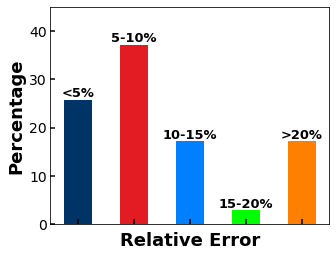

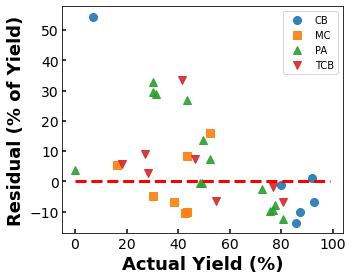

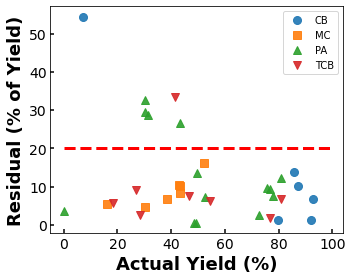

In [65]:
# make the numbers on axis bold
from matplotlib import rc, rcParams
error_group = ['<5%', '5-10%', '10-15%', '15-20%', '>20%']

abs_err = np.abs(pred_test.reshape(-1, 1)-test_labels.reshape(-1, 1))
less_5 = abs_err [abs_err <= 5]
larger_5 = abs_err [abs_err > 5]
larger_5_less_10 = larger_5 [larger_5 <= 10]
larger_10 = abs_err [abs_err > 10]
larger_10_less_15 = larger_10 [larger_10 <= 15]

larger_15 = abs_err [abs_err > 15]
larger_15_less_20 = larger_15 [larger_15 <= 20]
larger_20 = abs_err [abs_err > 20]
n_test = pred_test.shape[0]

#rc('font', weight='bold')
plt.close()
plt.figure(figsize = (5, 4))
frequencies = [less_5.shape[0]/n_test*100, larger_5_less_10.shape[0]/n_test*100, 
               larger_10_less_15.shape[0]/n_test*100, larger_15_less_20.shape[0]/n_test*100, 
               larger_20.shape[0]/n_test*100]
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', color = ['#003366', '#E31B23', '#007FFF', '#00FF00', '#FF7F00', '#959595'])
ax.tick_params(axis='both', which='major', labelsize=28, width=5)
rects = ax.patches
x_labels = [ ]
labels = ['<5%', '5-10%', '10-15%', '15-20%', '>20%']

ax.tick_params(axis='x', direction='in', length=5, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='in', length=5, width=1.5, colors='black', grid_alpha=0, labelsize='14')

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label,fontsize = 13, fontweight='bold',
            ha='center', va='bottom')
ax.set_xticklabels(x_labels)
plt.ylim(0, 45)

plt.yticks(fontsize = 14)
plt.ylabel("Percentage", fontsize=18, fontweight='bold')
plt.xlabel("Relative Error", fontsize=18, fontweight='bold')
plt.savefig('RE_dft_des.jpeg', dpi=300, bbox_inches='tight')

pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = (pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']

groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend()

x = list(range(0, 100))
y = np.repeat(0, 100)
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (% of Yield)', fontsize='18', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('resVSGY_test.png', dpi=200)

pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = abs(pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']

groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend()

x2 = list(range(0, 100))
y2 = np.repeat(20, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (% of Yield)', fontsize='18', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY_test.png', dpi=200)

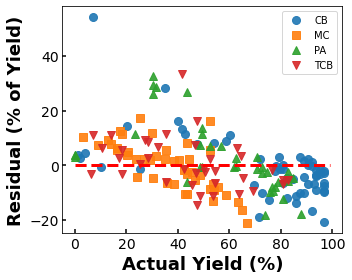

In [66]:
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = (predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend()


x = list(range(0, 100))
y = np.repeat(0, 100)
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (% of Yield)', fontsize='18', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('resVSGY.png', dpi=200)

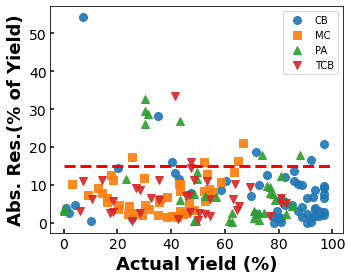

In [67]:
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = abs(predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend()

ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Res.(% of Yield)', fontsize='18', fontname='Arial', fontweight='bold')

x2 = list(range(0, 100))
y2 = np.repeat(15, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')

plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY.png', dpi=200)

/tmp/ipykernel_483015/2930675285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = pred_test
/tmp/ipykernel_483015/2930675285.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_true'] = test_labels


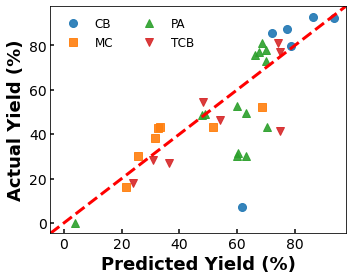

In [68]:
df_test = df.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels
groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
#plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2, y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.show()
#plt.savefig('XGBPerformance_materialgroup.png', dpi=300)


/tmp/ipykernel_483015/4245381040.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cv_class'] = cv_class


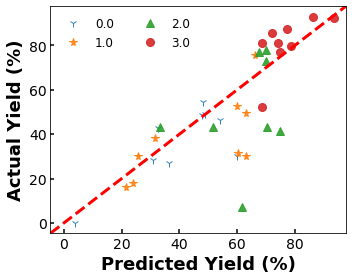

In [69]:
# Distribution of Graphene_yield with  CD density groups
cv = np.array (df_test['charge_density'])
Qs = np.quantile (cv, [0.25, 0.5, 0.75])

cv_class = cv
cv_class = np.where(cv <= Qs[0], 0, cv_class)
cv_class = np.where((cv > Qs[0]) & (cv <= Qs[1]), 1, cv_class)
cv_class = np.where((cv > Qs[1]) & (cv <= Qs[2]), 2, cv_class)
cv_class = np.where(cv > Qs[2], 3, cv_class)

# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)
df_test['cv_class'] = cv_class
groups = df_test.groupby(['cv_class'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['1', '*', '^', 'o']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_cvgroup.png', dpi=300)
plt.show()

In [70]:
# Get numerical feature importances
importances = list(xgbr_graphyield.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];
print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.06)
Variable: material_ps Importance: ('material_ps', 0.06)
Variable: material_res Importance: ('material_res', 0.0)
Variable: material_sa Importance: ('material_sa', 0.0)
Variable: material_sp2 Importance: ('material_sp2', 0.0)
Variable: material_CB Importance: ('material_CB', 0.0)
Variable: material_MC Importance: ('material_MC', 0.0)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_TCB Importance: ('material_TCB', 0.0)
Variable: PulseTime Importance: ('PulseTime', 0.05)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.04)
Variable: physicsbased_model Importance: ('physicsbased_model', 0.48)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.04)
Variable: Final_Current_Percent Importance: ('Final_Current_Percent', 0.04)
Variable: Norm_I_Max Importance: ('Norm_I_Max', 0.04)
Variable: Norm_charge_tot Importance: ('Norm_char

Mean Absolute Error: 30.2551 units.


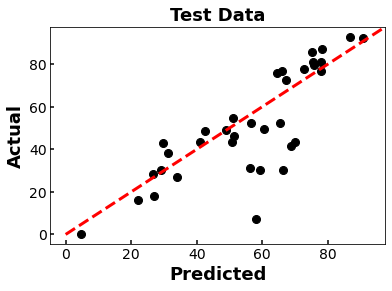

In [65]:
pred_test = xgbr_graphyield.predict(test_new_features)
errors_test= abs(pred_train - train_labels)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
# ax.set_xlim(20,105)
# ax.set_ylim(20,105)

# Predicted 2D/G
plt.plot(pred_test, test_labels, 
         linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Predicted', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Actual', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

Mean of I Max CB is  199.5962952631579
Mean of I Max MC is  546.874309090909
Mean of I Max PA is  301.9472116666666
Mean of I Max TCB is  217.5159437837838


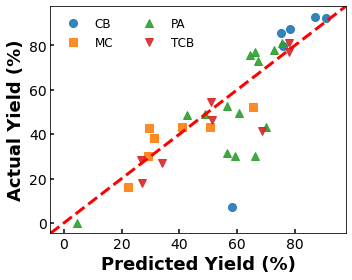

In [66]:
def category_normalization_theonesyoualwaysuse(df):
    groups = df.groupby(['Material'])
    norm_I_Max = []
    norm_charge_tot=[]
    for name, group in groups:
        I_Max_array = np.asfarray(group.I_Max)
        charge_tot_array = np.asfarray(group.Charge_Tot)
        mean_I_Max = np.mean(I_Max_array)
        mean_charge_tot = np.mean(charge_tot_array)
        std_I_Max = np.std(I_Max_array)
        std_charge_tot = np.std(charge_tot_array)
        print("Mean of I Max", name, "is ", mean_I_Max)
        norm_I_Max_cat = np.divide(np.subtract(I_Max_array, mean_I_Max), std_I_Max)
        norm_charge_tot_cat = np.divide(np.subtract(charge_tot_array, mean_charge_tot), std_charge_tot)
        norm_I_Max = np.append(norm_I_Max, norm_I_Max_cat)
        norm_charge_tot = np.append(norm_charge_tot, norm_charge_tot_cat)
    return norm_I_Max, norm_charge_tot


# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Import file
df_test = pd.read_csv('FJH_ML_Final.csv', header=1)
# Create normalized I by category
norm1, norm2 = category_normalization_theonesyoualwaysuse(df_test)
df_test['Norm_I_Max'] = norm1
df_test['Norm_charge_tot'] = norm2
df_test['charge_density'] = df_test['Voltage']*df_test['Cap']/df_test['Mass']
# df_test['test_feature'] = (df_test['Voltage']/df_test['Mass'])#*df_test['PulseTime']
# df_test = df_test[df_test['TwoDtoG']<1.5]
# df_test = df_test[df_test['Graphene_Yield']>20]

# Cut dataframe to only the test set
df_test = df_test.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels

groups = df_test.groupby(['Material'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_materialgroup.png', dpi=300)
plt.show()

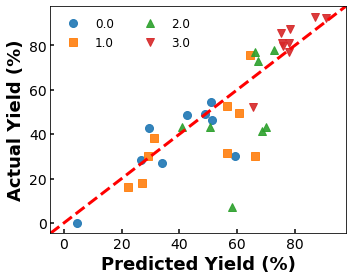

In [67]:
# Distribution of Graphene_yield with  CD density groups
cv = np.array (df_test['charge_density'])
Qs = np.quantile (cv, [0.25, 0.5, 0.75])

cv_class = cv
cv_class = np.where(cv <= Qs[0], 0, cv_class)
cv_class = np.where((cv > Qs[0]) & (cv <= Qs[1]), 1, cv_class)
cv_class = np.where((cv > Qs[1]) & (cv <= Qs[2]), 2, cv_class)
cv_class = np.where(cv > Qs[2], 3, cv_class)

# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)
df_test['cv_class'] = cv_class
groups = df_test.groupby(['cv_class'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_cvgroup.png', dpi=300)
plt.show()

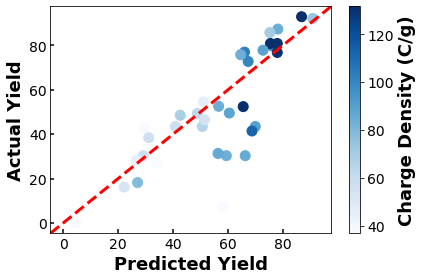

In [68]:
# Plot pred vs. true values for test set, coloring the charge density
groups = df_test.groupby(['Material'])
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')


for name, group in groups:
    p = ax.scatter(group.y_pred, group.y_true, c=group.charge_density, marker='o', s=100, cmap='Blues')
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('Charge Density (C/g)', fontsize='18', fontname='Arial', fontweight='bold')
cb.ax.tick_params(labelsize=14)

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
# ax.legend(fontsize=12)

# Plot
# plt.plot(df['I_Max'],df['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
# plt.savefig('xgbr_Regression_Performance_colorChargeDensity.png', dpi=300)
plt.show()

In [69]:
# outside test (Need to ask Jacob the details, material, atmosphere)
filename = 'FJH_ML_MBO_Yield4_modified.csv'
df_testBO0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
df_testBO = df_testBO0

# Only works for test that are TCB material !!!!!!
Material_CB_testBO = np.array (df_testBO['Material']).reshape(-1, 1)
Material_CB_testBO [:] = 0
Material_MC_testBO = np.zeros_like (Material_CB_testBO)
Material_PA_testBO = np.zeros_like (Material_CB_testBO)
Material_TCB_testBO = np.zeros_like (Material_CB_testBO)
Material_TCB_testBO [:] = 1
material_type_testBO = np.concatenate ((Material_CB_testBO, 
                                        Material_MC_testBO, 
                                        Material_PA_testBO,
                                        Material_TCB_testBO), axis=1)
# multiply constants to the matrix for the materials
# the constant calculated from [Init_R, Res_Drop, Volt_Drop] --> current quantities
material_type_GY_coef_testBO = material_type_testBO * CB_MC_PA_TCB_coef_average

# assumed the experiments were done under vaccum
Atmosphere_air_testBO = np.array (df_testBO['Atmosphere']).reshape(-1, 1)
Atmosphere_air_testBO [:] = 0
Atmosphere_arg_testBO = np.zeros_like (Atmosphere_air_testBO)
atmosphere_type_testBO = np.concatenate ((Atmosphere_air_testBO, 
                                          Atmosphere_arg_testBO ), axis=1)

# base 60mF as base and the number in excel file of 18mF
df_testBO['Cap'] = 60 + df_testBO['Cap']*18
charge_density_testBO = np.array (df_testBO['Voltage']*df_testBO['Cap']/
                                  df_testBO['Mass']).reshape(-1, 1)
pulsetime_testBO = np.array (df_testBO['PulseTime']).reshape(-1, 1)
Pretreat_voltage_testBO = np.array (df_testBO['Pretreat_voltage']).reshape(-1, 1)
voltage_testBO = np.array (df_testBO['Voltage']).reshape(-1, 1)
mass_testBO = np.array (df_testBO['Mass']).reshape(-1, 1)
Graphene_Yield_testBO = np.array (df_testBO['Graphene_Yield']).reshape(-1, 1)

In [70]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef_testBO = material_type_testBO*CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef_testBO = material_type_testBO*CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef_testBO = material_type_testBO*CB_MC_PA_coef_Norm_charge_tot

# the features should follow the same order as fitting the model
# 1) Final_I prediction
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_I_Finalperc_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Final_Current_Percent_predicted_testBO = xgbr_final_I_percent.predict(features_testBO)

# 2) norm_I_Max prediction
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_Norm_I_Max_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Norm_I_Max_predicted_testBO = xgbr_norm_I_max.predict(features_testBO)

# 3) norm_Charge_total
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_Norm_charge_Tot_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Norm_charge_tot_testBO = xgbr_norm_charge_total.predict(features_testBO)

In [71]:
# physics model prediction: fixed model (trained coefficients) predicting GY
X_CB_MC_PA_TCB_ps_res_sa_sp2_BO = np.matmul(material_type_testBO, 
                                            CB_MC_PA_TCB_ps_res_sa_sp2)
phys_mdl_input = np.concatenate((np.array(((df_testBO['Voltage']**1)*
                                  ((df_testBO['Mass']/100)**-1)*
                                  (df_testBO['Cap']**1))**1*1e-9).reshape(-1, 1),
                                  ((np.array(df_testBO['Pretreat_voltage'])**1)*1e-2).reshape(-1, 1),
                                  ((Norm_I_Max_predicted_testBO.reshape(-1, 1))**1)*1e-2,
                                  (np.array(df_testBO['PulseTime']).reshape(-1, 1))**0.5,
                                  ((np.array(Norm_charge_tot_testBO.reshape(-1, 1)))**1)*1e-2,
                                  (np.array (df_testBO['Mass']).reshape (-1, 1))*1e-2 ,
                                  (np.array (df_testBO['Cap']).reshape (-1, 1))*1e-1,
                                  X_CB_MC_PA_TCB_ps_res_sa_sp2_BO,
                                  ), axis=1)
phys_pred_BO = phys_reg_mdl.predict (phys_mdl_input)
r2_score (Graphene_Yield_testBO, phys_pred_BO)

-34817.06051344648

In [72]:
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix_BO = np.matmul(material_type_testBO, CB_MC_PA_TCB_res)
heat_power_BO = np.array (df_testBO['Voltage']*df_testBO['Voltage']/
                          resistance_matrix_BO*df_testBO['PulseTime']*(1e-6)).reshape(-1, 1)

features_testBO = np.concatenate ((charge_density_testBO,
                                   X_CB_MC_PA_TCB_ps_res_sa_sp2_BO,
                                   material_type_GY_coef_testBO,
                                   pulsetime_testBO,
                                   Pretreat_voltage_testBO,
                                   phys_pred_BO.reshape(-1, 1),
                                   atmosphere_type_testBO,
                                   Final_Current_Percent_predicted_testBO.reshape(-1, 1),
                                   Norm_I_Max_predicted_testBO.reshape(-1, 1),
                                   Norm_charge_tot_testBO.reshape(-1, 1),
                                   heat_power_BO
                                  ), axis=1)

In [73]:
graphene_yield_testBO = np.array (df_testBO['Graphene_Yield']).reshape(-1, 1)
graphene_yield_testBO = 100*graphene_yield_testBO
graphene_yield_testBO_predicted = xgbr_graphyield.predict (features_testBO)

print ('R-squared: ', r2_score(graphene_yield_testBO, graphene_yield_testBO_predicted))
print ('RMSE: ', np.sqrt(mean_squared_error(graphene_yield_testBO, graphene_yield_testBO_predicted)))

R-squared:  -0.3734371327938535
RMSE:  30.856184568656964


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


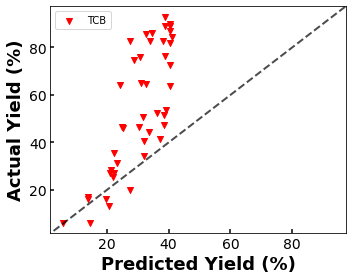

In [74]:
# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
plt.scatter (graphene_yield_testBO_predicted, graphene_yield_testBO, marker='v', 
             color='red', label='TCB')


ax.legend('TCB', fontsize=12, loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

ax.set_xlim(min(xmin, ymin), max(ymax, xmax))
ax.set_ylim(min(xmin, ymin), max(ymax, xmax))
# Make a red line to show perfect predictions
x2 = np.arange(0, 100)
y2 = np.arange(0, 100)
#y2 = np.arange(0.1*ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='black', alpha=0.7)
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('XGBoost_testBOsamples.png', dpi=300)
plt.show()

In [75]:
# Future experimental trial: call it newexp
filename = 'New_experimental_trial.csv'
df_newexp0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=0)
df_newexp = df_newexp0.copy()

# the prediction range should cover a large range
#df_newexp['Voltage'] = df_newexp0 ['Voltage'] - 20
#df_newexp['Mass'] = df_newexp0 ['Mass'] + 20

# Only works for test that are TCB material !!!!!!
material_type_newexp = np.asarray (df_newexp.loc[:, ('CB_per', 'MC_per', 'PA_per', 'TCB_per')])
# multiply constants to the matrix for the materials
# the constant calculated from [Init_R, Res_Drop, Volt_Drop] --> current quantities
material_type_GY_coef_newexp = material_type_newexp * CB_MC_PA_TCB_coef_average

# assumed the experiments were done under vaccum
atmos_dummies = pd.get_dummies(df_newexp['Atmosphere_type'])
atmosphere_type_newexp = np.concatenate ((np.array(atmos_dummies['air']).reshape(-1, 1), 
                                          np.array(atmos_dummies['arg']).reshape(-1, 1)), axis=1)

# base 60mF as base and the number in excel file of 18mF
df_newexp['Cap'] = df_newexp['Cap']
charge_density_newexp = np.array (df_newexp['Voltage']*df_newexp['Cap']/
                                  df_newexp['Mass']).reshape(-1, 1)
pulsetime_newexp = np.array (df_newexp['PulseTime']).reshape(-1, 1)
Pretreat_voltage_newexp = np.array (df_newexp['Pretreat_voltage']).reshape(-1, 1)
voltage_newexp = np.array (df_newexp['Voltage']).reshape(-1, 1)
mass_newexp = np.array (df_newexp['Mass']).reshape(-1, 1)
Graphene_Yield_newexp = np.array (df_newexp['Average_Graphene_Yield']).reshape(-1, 1)

In [76]:
material_type_GY_coef_newexp

array([[ 0.00698084, -0.        , -0.00295613, -0.        ],
       [ 0.00698084, -0.        , -0.00295613, -0.        ],
       [ 0.        , -0.00147468, -0.        , -0.00254853],
       [ 0.        , -0.        , -0.00295613, -0.00254853],
       [ 0.        , -0.00147468, -0.00295613, -0.        ],
       [ 0.        , -0.00147468, -0.        , -0.00254853],
       [ 0.00698084, -0.00147468, -0.        , -0.        ],
       [ 0.00698084, -0.00147468, -0.        , -0.        ],
       [ 0.        , -0.00147468, -0.00295613, -0.        ],
       [ 0.00698084, -0.00147468, -0.        , -0.        ],
       [ 0.00698084, -0.        , -0.00295613, -0.        ],
       [ 0.00698084, -0.00147468, -0.        , -0.        ],
       [ 0.        , -0.00147468, -0.        , -0.00254853],
       [ 0.00698084, -0.00147468, -0.        , -0.        ],
       [ 0.00698084, -0.00147468, -0.        , -0.        ],
       [ 0.00698084, -0.        , -0.        , -0.00254853],
       [ 0.00698084, -0.

In [77]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef_newexp = material_type_newexp*CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef_newexp = material_type_newexp*CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef_newexp = material_type_newexp*CB_MC_PA_coef_Norm_charge_tot

# the features should follow the same order as fitting the model
# 1) Final_I prediction
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_I_Finalperc_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Final_Current_Percent_predicted_newexp = xgbr_final_I_percent.predict(features_newexp)

# 2) norm_I_Max prediction
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_Norm_I_Max_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Norm_I_Max_predicted_newexp = xgbr_norm_I_max.predict(features_newexp)

# 3) norm_Charge_total
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_Norm_charge_Tot_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Norm_charge_tot_newexp = xgbr_norm_charge_total.predict(features_newexp)

In [78]:
# physics model prediction: fixed model (trained coefficients) predicting GY
X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp = np.matmul(material_type_newexp, 
                                            CB_MC_PA_TCB_ps_res_sa_sp2)
phys_mdl_input = np.concatenate((np.array(((df_newexp['Voltage']**1)*
                                  ((df_newexp['Mass']/100)**-1)*
                                  (df_newexp['Cap']**1))**1*1e-9).reshape(-1, 1),
                                  ((np.array(df_newexp['Pretreat_voltage'])**0.5)*1e-2).reshape(-1, 1),
                                  ((Norm_I_Max_predicted_newexp.reshape(-1, 1))**1)*1e-2,
                                  (np.array(df_newexp['PulseTime']).reshape(-1, 1))**0.5,
                                  ((np.array(Norm_charge_tot_newexp.reshape(-1, 1)))**1)*1e-2,
                                  (np.array (df_newexp['Mass']).reshape (-1, 1))*1e-2 ,
                                  (np.array (df_newexp['Cap']).reshape (-1, 1))*1e-1,
                                  X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp,
                                  ), axis=1)
phys_pred_newexp = phys_reg_mdl.predict (phys_mdl_input)
r2_score (Graphene_Yield_newexp, phys_pred_newexp)

-42.86381569915066

In [89]:
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix_newexp = np.matmul(material_type_newexp, CB_MC_PA_TCB_res)
heat_power_newexp = np.array (df_newexp['Voltage']*df_newexp['Voltage']/
                          resistance_matrix_newexp*df_newexp['PulseTime']*(1e-6)).reshape(-1, 1)

features_newexp = np.concatenate ((charge_density_newexp,
                                   X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp,
                                   material_type_GY_coef_newexp,
                                   pulsetime_newexp,
                                   Pretreat_voltage_newexp,
                                   phys_pred_newexp.reshape(-1, 1),
                                   atmosphere_type_newexp,
                                   Final_Current_Percent_predicted_newexp.reshape(-1, 1),
                                   Norm_I_Max_predicted_newexp.reshape(-1, 1),
                                   Norm_charge_tot_newexp.reshape(-1, 1),
                                   heat_power_newexp
                                  ), axis=1)

In [90]:
graphene_yield_newexp = np.array (df_newexp['Average_Graphene_Yield']).reshape(-1, 1)
graphene_yield_newexp = 100*graphene_yield_newexp
graphene_yield_newexp_predicted = xgbr_graphyield.predict (features_newexp)

print ('R-squared: ', r2_score(graphene_yield_newexp, graphene_yield_newexp_predicted))
print ('RMSE: ', np.sqrt(mean_squared_error(graphene_yield_newexp, graphene_yield_newexp_predicted)))

R-squared:  -8.176964662438051
RMSE:  5402.820337756183


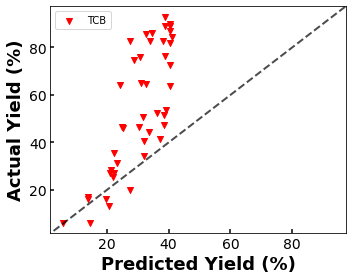

In [81]:
# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
plt.scatter (graphene_yield_testBO_predicted, graphene_yield_testBO, marker='v', 
             color='red', label='TCB')


ax.legend('TCB', fontsize=12, loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

ax.set_xlim(min(xmin, ymin), max(ymax, xmax))
ax.set_ylim(min(xmin, ymin), max(ymax, xmax))
# Make a red line to show perfect predictions
x2 = np.arange(0, 100)
y2 = np.arange(0, 100)
#y2 = np.arange(0.1*ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='black', alpha=0.7)
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('XGBoost_testBOsamples.png', dpi=300)
plt.show()

In [82]:
df_newexp['mlpred_Graphene_Yield'] = graphene_yield_newexp_predicted
df_newexp

,Sample,CB_per,MC_per,PA_per,TCB_per,Atmosphere_type,Mass,Pretreat_voltage,Voltage,PulseTime,Cap,Average_Graphene_Yield,mlpred_Graphene_Yield
0,1,0.5,0.0,0.5,0.0,vac,218,260,212,616,123,82.106782,30.854782
1,2,0.5,0.0,0.5,0.0,vac,162,185,207,259,105,77.509470,38.333843
2,3,0.0,0.5,0.0,0.5,vac,311,220,218,439,123,49.766900,23.895056
3,4,0.0,0.0,0.5,0.5,vac,233,150,164,154,105,38.383838,30.949862
4,5,0.0,0.5,0.5,0.0,vac,231,330,197,380,96,42.095960,17.796835
5,6,0.0,0.5,0.0,0.5,vac,211,162,214,222,141,64.574315,36.320053
6,7,0.5,0.5,0.0,0.0,air,242,275,208,77,123,56.060606,33.331100
7,8,0.5,0.5,0.0,0.0,vac,222,150,177,168,96,22.799423,17.014296
8,9,0.0,0.5,0.5,0.0,air,289,240,185,216,105,34.738691,33.757877
9,10,0.5,0.5,0.0,0.0,air,240,240,195,318,123,63.318055,32.708710


min of pred GY 14.4507
max of pred GY 38.333843


/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Average_Graphene_Yield', ylabel='Density'>

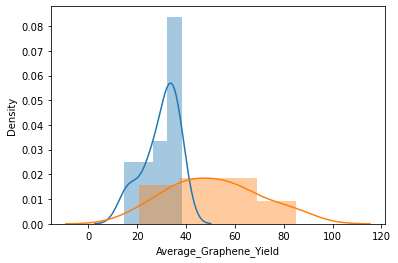

In [83]:
print ('min of pred GY', np.min (df_newexp['mlpred_Graphene_Yield']))
print ('max of pred GY', np.max (df_newexp['mlpred_Graphene_Yield']))
sns.distplot (df_newexp['mlpred_Graphene_Yield'])
sns.distplot (df_newexp['Average_Graphene_Yield'])

In [84]:
print (np.min (df_newexp['Average_Graphene_Yield']))
print (np.max (df_newexp['Average_Graphene_Yield']))

20.946969699999997
85.20923524999999


In [85]:
print (np.min (df_newexp['mlpred_Graphene_Yield']))
print (np.max (df_newexp['mlpred_Graphene_Yield']))


14.4507
38.333843


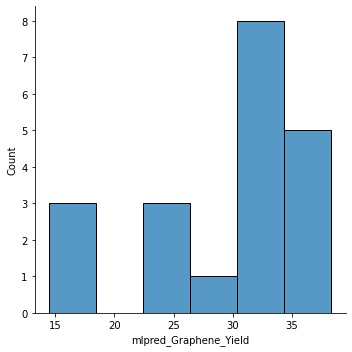

In [86]:
sns.displot (df_newexp['mlpred_Graphene_Yield'])

(0.4641847244822059, 0.03923060591685649)
-1.2432052914985663


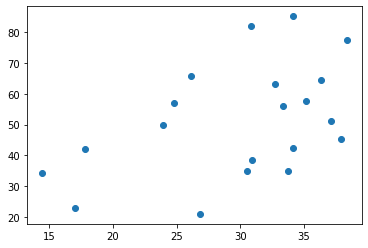

In [87]:
print (pearsonr (df_newexp['mlpred_Graphene_Yield'], df_newexp['Average_Graphene_Yield']))
print (r2_score (df_newexp['Average_Graphene_Yield'], df_newexp['mlpred_Graphene_Yield']))
plt.scatter (df_newexp['mlpred_Graphene_Yield'], df_newexp['Average_Graphene_Yield'])

In [88]:
print ('End!!!')

End!!!
